In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests
import random
import collections
from tqdm.notebook import tqdm as tqdm_notebook
import folium

In [2]:
df_traits = pd.read_pickle("plant_traits")

In [3]:
# Read files
HTML_locations = glob.glob('../../data/raw/POWO/*')

In [4]:
plant_locations = collections.defaultdict(list)
for HTML in tqdm(HTML_locations[0:]):
    
    species = HTML[20:].split(' - ')[0]
    if species not in df_traits['Plant'].unique():
        continue
    
    with open(HTML) as f:
        soup = BeautifulSoup(f, 'html.parser')
        
        chapters = soup.find_all('h3')
        for chapter in chapters:
            if chapter.text == 'Native to:' or chapter.text == 'Introduced into:':
                tag = chapter
                location_tag = list(tag.next_sibling.next_sibling)[0]
                location_candidates = location_tag.split('\n')
                for candidate in location_candidates:
                    candidate = candidate.strip().replace(',', '')
                    if candidate:
                        plant_locations[species].append(candidate)
 

  0%|          | 0/40187 [00:00<?, ?it/s]

In [5]:
#colours = [ "red", "blue", "green", "yellow", "purple", "orange", "white",]

In [6]:
#plant_traits = collections.defaultdict(list)
#for species in plant_locations.keys():
#    colour = random.choice(colours)
#    plant_traits[species] = colour


In [7]:
plant_traits = collections.defaultdict(list)
for plant in tqdm_notebook(df_traits['Plant'].unique(), desc='Plant'):
    df_subset = df_traits[df_traits['Plant'] == plant]

    traits = df_subset.groupby(['Trait']).count().sort_values('Sentence').index
    traits = list(traits)
    traits.reverse()
    
    plant_traits[plant]+=(traits)

Plant:   0%|          | 0/99 [00:00<?, ?it/s]

In [8]:
country_traits = collections.defaultdict(list)

for species in plant_locations.keys():
    for country in plant_locations[species]:
        country_traits[country]+=(plant_traits[species])

In [9]:
df = pd.DataFrame.from_dict(country_traits, orient='index')
df = df.T

In [10]:
country_list = []
for column in df.columns:
    series = df[column].value_counts()
    trait = series.index[0:1]
    amount = series[0]
    country_list.append((column, trait))

In [11]:
url = "https://raw.githubusercontent.com/tdwg/wgsrpd/master/geojson/level3.geojson"
gdf = gpd.read_file(url)

gdf.columns = ['Region',
              'ISO',
              'x2', 'x3',
              'geometry']

gdf = gdf.drop(columns=['x2', 'x3'])

In [12]:
gdf.insert(loc=2, column='Trait', value='black')

for (country, trait) in country_list:
    gdf.at[gdf.loc[gdf['Region'] == country].index, 'Trait'] = trait
    

In [13]:
gdf

,Region,ISO,Trait,geometry
0,Alberta,ABT,stemmed herb,"POLYGON ((-114.86111 50.40610, -116.26222 51.3..."
1,Afghanistan,AFG,lanceolate ovate,"POLYGON ((71.25447 38.30291, 71.36637 38.23631..."
2,Argentina Northeast,AGE,lower vein,"MULTIPOLYGON (((-61.87886 -39.24249, -62.05916..."
3,Argentina South,AGS,stemmed herb,"MULTIPOLYGON (((-68.60866 -54.89139, -68.64316..."
4,Argentina Northwest,AGW,lower vein,"POLYGON ((-65.74806 -22.11169, -64.67166 -22.1..."
...,...,...,...,...
364,Yugoslavia,YUG,subopposite leaflets,"MULTIPOLYGON (((16.90384 42.72611, 16.82224 42..."
365,Yukon,YUK,stemmed herb,"MULTIPOLYGON (((-136.42081 68.90159, -136.4416..."
366,Zaïre,ZAI,1 floret,"MULTIPOLYGON (((12.95307 -5.87609, 12.86497 -5..."
367,Zambia,ZAM,1 floret,"POLYGON ((31.11947 -8.61499, 31.48557 -8.66639..."


In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

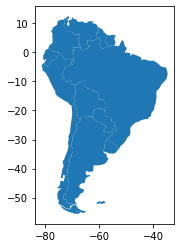

In [15]:
world[world['continent'] == 'South America'].plot()

In [40]:
#SA = gdf.intersection(world[world['continent'] == 'South America'], align=True)


SA = gdf.overlay(world[world['continent'] == 'South America'], how='intersection')

In [42]:
SA = SA.dissolve(by='Region', aggfunc='first')
SA['Region'] = SA.index

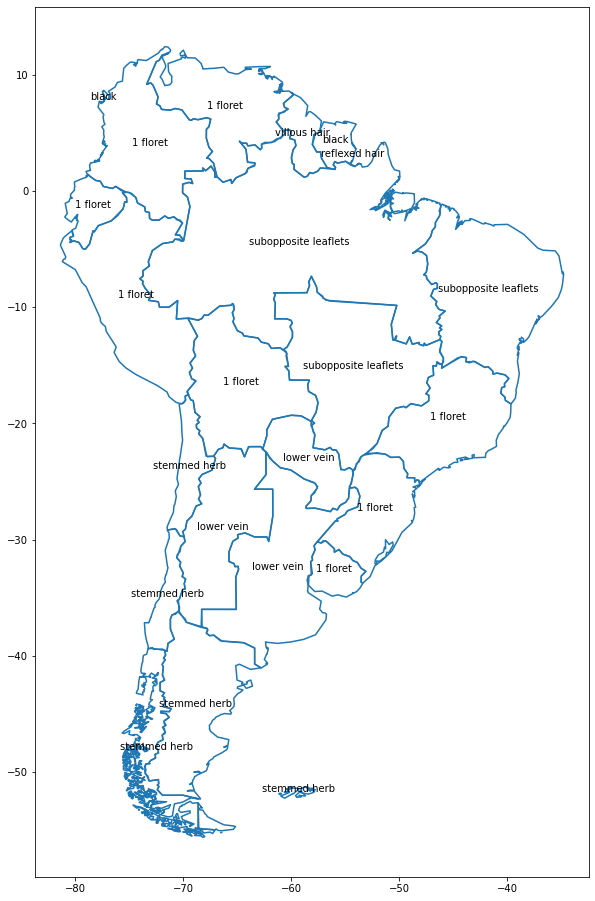

In [43]:
ax = SA.boundary.plot(figsize=(20, 16))
SA.apply(lambda x: ax.annotate(text=x['Trait'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [ ]:
m = folium.Map(location=[51.973, 5.655], zoom_start=4, tiles='CartoDB positron')

In [ ]:
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Trait']).add_to(geo_j)
    geo_j.add_to(m)



# Word Clouds

In [16]:
import numpy as np
import pandas as pd
from os import path
import cv2
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
text = """
The European robin was described by Carl Linnaeus in 1758 in the 10th edition of his Systema Naturae under the binomial name Motacilla rubecula.[2] Its specific epithet rubecula is a diminutive derived from the Latin ruber 'red'.[3][4] The genus Erithacus was introduced by French naturalist Georges Cuvier in 1800, giving the bird its current binomial name E. rubecula.[5][6] The genus name Erithacus is from Ancient Greek[7] and refers to an unknown bird, now usually identified as robin.[8]

The distinctive orange breast of both sexes contributed to the European robin's original name of "redbreast", orange as a colour name being unknown in English until the 16th century, by which time the fruit had been introduced. In the 15th century, when it became popular to give human names to familiar species, the bird came to be known as robin redbreast, which was eventually shortened to robin.[9] As a given name, Robin is originally a diminutive of Robert. Other older English names for the bird include ruddock and robinet. In American literature of the late 19th century, this robin was frequently called the English robin.[10] Dutch roodborstje, French rouge-gorge, German Rotkehlchen, Italian pettirosso, Spanish petirrojo and Portuguese pisco-de-peito-ruivo all refer to the distinctively coloured front.[11]

The genus Erithacus previously included the Japanese robin and the Ryukyu robin. These east Asian species were shown in molecular phylogenetic studies to be more similar to a group of other Asian species than to the European robin.[12][13] In a reorganisation of the genera, the Japanese and the Ryukyu robins were moved to the resurrected genus Larvivora leaving the European robin as the sole member of Erithacus.[14] The phylogenetic analysis placed Erithacus in the subfamily Erithacinae, which otherwise contained only African species, but its exact position with respect to the other genera was not resolved.[13]

The genus Erithacus was formerly classified as a member of the thrush family (Turdidae) but is now considered to belong to the Old World flycatcher family (Muscicapidae), specifically to the chats (subfamily Saxicolinae) which also include the common nightingale.[15]
Subspecies

In their large continental Eurasian range, robins vary somewhat, but do not form discrete populations that might be considered subspecies.[16][17] Robin subspecies are mainly distinguished by forming resident populations on islands and in mountainous areas. The robin found in the British Isles and much of western Europe, Erithacus rubecula melophilus, occurs as a vagrant in adjacent regions. E. r. witherbyi from northwest Africa, Corsica, and Sardinia closely resembles melophilus but has shorter wings.[18] The northeasternmost birds, large and fairly washed-out in colour, are E. r. tataricus. In the southeast of its range, E. r. valens of the Crimean Peninsula, E. r. caucasicus of the Caucasus and northern Transcaucasia, and E. r. hyrcanus southeastwards into Iran are generally accepted as significantly distinct.[18] 
"""

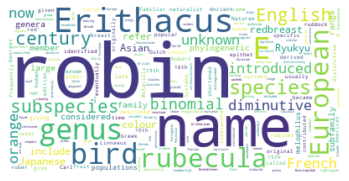

In [18]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()
plt.savefig("output.png")
image = plt.imread("output.png")

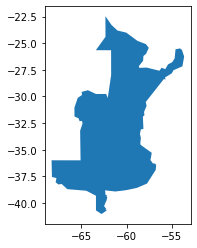

In [48]:
plot = SA[SA.Region == 'Argentina Northeast'].plot()

In [49]:
plot.set_axis_off()
fig = plot.get_figure()
fig.savefig("mask.png", bbox_inches='tight')
mask = plt.imread("mask.png")
mask = 255 * mask
mask = mask.astype(np.uint8)

In [54]:
text = '. '.join(country_traits['Argentina Northeast'])

In [23]:
d = {}
for traint in country_traits['Argentina Northeast']:
    d[traint] = random.randrange(1, 15)

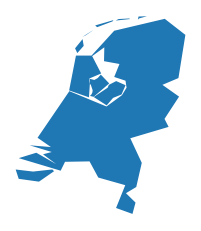

In [24]:
plot = gdf[gdf.Region == 'Netherlands'].plot()
plot.set_axis_off()
fig = plot.get_figure()
fig.savefig("mask.png", bbox_inches='tight')
mask = plt.imread("mask.png")
mask = 255 * mask
mask = mask.astype(np.uint8)

In [25]:
scale_percent = 500 # percent of original size
width = int(mask.shape[1] * scale_percent / 100)
height = int(mask.shape[0] * scale_percent / 100)
dim = (width, height)


mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)

In [26]:
mask.shape

(1155, 1005, 4)

In [27]:
wordcloud = WordCloud(max_font_size=100, 
                      max_words=200,
                      width=width, height=height,
                      background_color=None,
                      mode='RGBA',
                      collocations=False,
                      contour_width=3, 
                      contour_color='steelblue',
                      repeat=True,
                      mask=mask).generate_from_frequencies(d)

# Display the generated image:
#plt.figure( figsize=(10, 10), facecolor='k' )
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.tight_layout(pad=0)
#plt.axis("off")

#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight',)
#plt.show()

In [28]:
svg = wordcloud.to_svg('test.svg')

In [29]:
with open('wordcloud.svg', 'w+') as f:
    f.write(svg)